--- Starting Episode 1 ---
Episode 1 completed. Total reward: 277780.24, Avg highway flow: 3.59, Avg ramp queue: 0.32
--- Starting Episode 2 ---
Episode 2 completed. Total reward: 276501.86, Avg highway flow: 3.57, Avg ramp queue: 0.32
--- Starting Episode 3 ---
Episode 3 completed. Total reward: 280870.02, Avg highway flow: 3.74, Avg ramp queue: 0.32
--- Starting Episode 4 ---
Episode 4 completed. Total reward: 280823.94, Avg highway flow: 3.71, Avg ramp queue: 0.33
--- Starting Episode 5 ---
Episode 5 completed. Total reward: 276967.04, Avg highway flow: 3.60, Avg ramp queue: 0.33
--- Starting Episode 6 ---
Episode 6 completed. Total reward: 280848.15, Avg highway flow: 3.72, Avg ramp queue: 0.32
--- Starting Episode 7 ---
Episode 7 completed. Total reward: 279229.64, Avg highway flow: 3.65, Avg ramp queue: 0.31
--- Starting Episode 8 ---
Episode 8 completed. Total reward: 282640.86, Avg highway flow: 3.79, Avg ramp queue: 0.33
--- Starting Episode 9 ---
Episode 9 completed. Total re

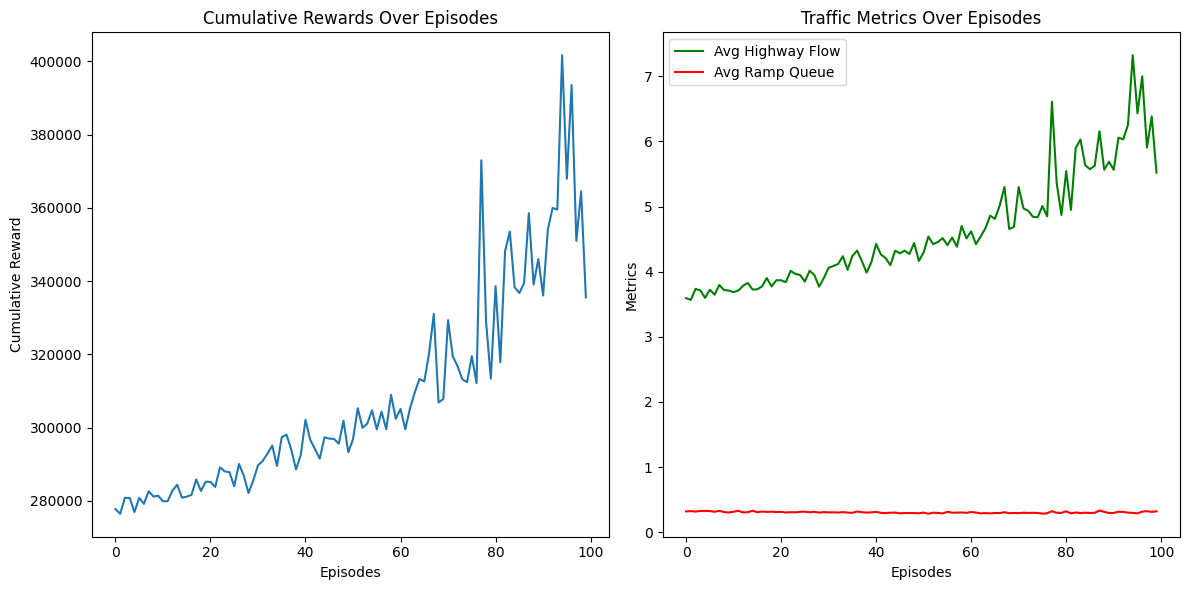

: 

In [1]:
import traci
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Hyperparameters
GAMMA = 0.95  # Discount factor
EPSILON = 1.0  # Initial exploration rate
EPSILON_DECAY = 0.995  # Epsilon decay rate
MIN_EPSILON = 0.01  # Minimum exploration rate
LEARNING_RATE = 0.001
NUM_EPISODES = 100
REPLAY_BUFFER_SIZE = 2000
BATCH_SIZE = 32
REPLAY_FREQUENCY = 10  # Perform replay every N steps
TARGET_UPDATE_FREQUENCY = 5  # Update target model every N episodes

# Replay buffer
replay_buffer = deque(maxlen=REPLAY_BUFFER_SIZE)

# Neural network model for Deep Q-Learning
def build_model(state_size, action_size):
    model = Sequential([
        tf.keras.Input(shape=(state_size,)),  # Explicitly define input layer
        Dense(24, activation='relu'),
        Dense(24, activation='relu'),
        Dense(action_size, activation='linear')
    ])
    model.compile(loss='mse', optimizer=Adam(learning_rate=LEARNING_RATE))
    return model

# Helper functions
def reset_simulation():
    """Reset the SUMO simulation to the starting point."""
    traci.load(["--net-file", "test1.net.xml", "--route-files", "test1.rou.xml", "--additional-files", "test1.add.xml"])
    return get_state()

def get_state():
    """Retrieve the current state of the system."""
    highway_traffic = min(traci.edge.getLastStepVehicleNumber("E0") / 10, 1)  # Normalize to [0, 1]
    ramp_queue = min(traci.edge.getLastStepVehicleNumber("E2") / 10, 1)  # Normalize to [0, 1]
    traffic_light_phase = traci.trafficlight.getPhase("J1") / 2  # Normalize phase to [0, 1]
    return np.array([highway_traffic, ramp_queue, traffic_light_phase])

def calculate_reward(highway_flow, ramp_queue, avg_speed):
    """Calculate the reward with adjusted weights."""
    reward = (2 * avg_speed) + (7 * highway_flow) - (5.0 * ramp_queue)
    return reward

def select_action(state, epsilon, action_size, model):
    """Select an action based on the epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.choice(range(action_size))  # Explore
    q_values = model.predict(state[np.newaxis, :], verbose=0)
    return np.argmax(q_values[0])  # Exploit

def replay_experience(model, target_model):
    """Perform experience replay to stabilize learning."""
    if len(replay_buffer) < BATCH_SIZE:
        return

    batch = random.sample(replay_buffer, BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = np.array(states)
    next_states = np.array(next_states)

    q_values_next = target_model.predict(next_states, verbose=0)
    q_values_target = model.predict(states, verbose=0)

    for i in range(BATCH_SIZE):
        target = rewards[i]
        if not dones[i]:
            target += GAMMA * np.amax(q_values_next[i])
        q_values_target[i][actions[i]] = target

    model.fit(states, q_values_target, epochs=1, verbose=0, batch_size=BATCH_SIZE)

# Initialize models and variables
state_size = 3
action_size = 3
model = build_model(state_size, action_size)
target_model = build_model(state_size, action_size)
target_model.set_weights(model.get_weights())

# Run simulation
sumo_binary = "sumo"
sumo_config_file = "test1.sumocfg"
traci.start([sumo_binary, "-c", sumo_config_file])

cumulative_rewards = []
avg_highway_flows = []
avg_ramp_queues = []

for episode in range(NUM_EPISODES):
    print(f"--- Starting Episode {episode + 1} ---")
    total_reward = 0
    state = reset_simulation()
    done = False
    step_count = 0

    episode_highway_flows = []
    episode_ramp_queues = []

    while not done:
        action = select_action(state, EPSILON, action_size, model)
        traci.trafficlight.setPhase("J1", action)

        if traci.simulation.getMinExpectedNumber() == 0:
            break

        traci.simulationStep()
        next_state = get_state()
        highway_flow = traci.edge.getLastStepVehicleNumber("E0")
        ramp_queue = traci.edge.getLastStepVehicleNumber("E2")
        avg_speed = traci.edge.getLastStepMeanSpeed("E0")
        reward = calculate_reward(highway_flow, ramp_queue, avg_speed)
        total_reward += reward

        done = traci.simulation.getMinExpectedNumber() == 0

        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state

        episode_highway_flows.append(highway_flow)
        episode_ramp_queues.append(ramp_queue)

        if step_count % REPLAY_FREQUENCY == 0:
            replay_experience(model, target_model)

        step_count += 1

    cumulative_rewards.append(total_reward)
    avg_highway_flows.append(np.mean(episode_highway_flows))
    avg_ramp_queues.append(np.mean(episode_ramp_queues))

    if episode % TARGET_UPDATE_FREQUENCY == 0:
        target_model.set_weights(model.get_weights())

    EPSILON = max(MIN_EPSILON, EPSILON * EPSILON_DECAY)

    print(f"Episode {episode + 1} completed. Total reward: {total_reward:.2f}, "
          f"Avg highway flow: {np.mean(episode_highway_flows):.2f}, "
          f"Avg ramp queue: {np.mean(episode_ramp_queues):.2f}")

traci.close()

# Plot Results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(cumulative_rewards)
plt.title("Cumulative Rewards Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")

plt.subplot(1, 2, 2)
plt.plot(avg_highway_flows, label="Avg Highway Flow", color="green")
plt.plot(avg_ramp_queues, label="Avg Ramp Queue", color="red")
plt.title("Traffic Metrics Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Metrics")
plt.legend()

plt.tight_layout()
plt.show()
